### PCA on feature-specific conditions

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.pseudo_utils as pseudo_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
from utils.session_data import SessionData
import utils.io_utils as io_utils
from constants.behavioral_constants import *
import json

from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)

import matplotlib.pyplot as plt
import matplotlib

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import plotly.express as px


In [3]:
# the output directory to store the data
OUTPUT_DIR = "/data/patrick_res/pseudo"
# path to a dataframe of sessions to analyze
# SESSIONS_PATH = "/data/patrick_scratch/multi_sess/valid_sessions.pickle"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
# path for each session, specifying behavior
SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"
# path for each session, for spikes that have been pre-aligned to event time and binned. 
# SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sess_name}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_1_smooth.pickle"
SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sess_name}_residual_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_1_smooth.pickle"

EVENT = "FeedbackOnset"  # event in behavior to align on
PRE_INTERVAL = 1300   # time in ms before event
POST_INTERVAL = 1500  # time in ms after event
INTERVAL_SIZE = 50  # size of interval in ms

In [4]:
FEATURE = "MAGENTA"
# FEATURE = "STAR"
# FEATURE = "CIRCLE"
# FEATURE = "TRIANGLE"
MIN_NUM_TRIALS = 20
CONDITIONS = ["MaxFeatMatches", "RPEGroup"]
# REGION = "hippocampal_formation (HF)"
# REGION = "orbital_frontal_cortex (OFC)"
# REGION = "all"

In [5]:
valid_sess = pd.read_pickle(SESSIONS_PATH)
units = spike_utils.get_unit_positions(valid_sess)
# region_units = units[units.manual_structure == "Prefrontal Cortex"]
# region_units = units[units.manual_structure == "Anterior Cingulate Gyrus"]
# region_units = units[units.manual_structure == "Hippocampus/MTL"]

# region_units = units[units.structure_level2 == REGION]
# region_units = units[units.structure_level3 == REGION]

region_units = units

In [6]:
units.manual_structure.unique()

array(['Claustrum', 'Prefrontal Cortex', 'Visual Cortex',
       'Anterior Cingulate Gyrus', 'Parietal Cortex', 'unknown',
       'Basal Ganglia', 'Hippocampus/MTL', 'Premotor Cortex', 'Amygdala'],
      dtype=object)

In [7]:
def validate_and_label_sessions(row, feature, region_units, shuffle=False, balance=True):
    # check region specificity:
    # if not row.session_name in region_units.session.values:
    #     return None
    labeled_beh = behavioral_utils.get_beh_model_labels_for_session_feat(row.session_name, feature)
    labeled_beh = labeled_beh[labeled_beh.Response == "Correct"]
    enough_trials = behavioral_utils.validate_enough_trials_by_condition(labeled_beh, CONDITIONS, MIN_NUM_TRIALS, num_unique_conditions=4)
    if not enough_trials:
        return None
    # TODO: determine whether or not this is needed: 
    if balance: 
        labeled_beh = behavioral_utils.balance_trials_by_condition(labeled_beh, CONDITIONS)
    # HACK: doesn't generalize to other conditions
    labeled_beh["Condition"] = labeled_beh.MaxFeatMatches.astype(str) + " " + labeled_beh.RPEGroup
    if shuffle: 
        rng = np.random.default_rng()
        vals = labeled_beh["Condition"].values
        rng.shuffle(vals)
        labeled_beh["Condition"] = vals
    frs_path = SESS_SPIKES_PATH.format(
        sess_name=row.session_name, 
        pre_interval=PRE_INTERVAL, 
        event=EVENT, 
        post_interval=POST_INTERVAL, 
        interval_size=INTERVAL_SIZE
    )
    frs = pd.read_pickle(frs_path)
    frs["PseudoUnitID"] = int(row.session_name) * 100 + frs["UnitID"]
    frs = frs[frs.PseudoUnitID.isin(region_units.PseudoUnitID)]
    merged = pd.merge(labeled_beh, frs, on="TrialNumber")
    if len(merged) == 0:
        return None
    return merged


In [60]:
def mean_sub_unit(group):
    mean = group.ConditionedFiringRate.mean()
    group["ConditionedFiringRate"] = group.ConditionedFiringRate - mean
    return group

def make_data_mat(all_trials, should_mean_sub=True):
    conditions = all_trials.Condition.unique()
    conditions.sort()
    conditioned_frs = all_trials.groupby(["Condition", "PseudoUnitID", "TimeBins"]).FiringRate.mean().to_frame("ConditionedFiringRate").reset_index()
    if should_mean_sub: 
        conditioned_frs = conditioned_frs.groupby("PseudoUnitID", group_keys=False).apply(mean_sub_unit).reset_index()
    conditioned_frs_sorted = conditioned_frs.sort_values(by=["PseudoUnitID", "Condition", "TimeBins"])
    num_units = len(conditioned_frs.PseudoUnitID.unique())
    num_conds = len(conditioned_frs.Condition.unique())
    num_time_bins = len(conditioned_frs.TimeBins.unique())
    data_mat = conditioned_frs_sorted.ConditionedFiringRate.values.reshape((num_units, num_conds * num_time_bins))
    return data_mat, conditioned_frs

def project_conditioned_firing_rates(all_trials):
    """
    Condition-average firing rates by Condition column,
    Calculate 1st 3 PCs of condition-averaged firing rates
    Return projected dataframe, PCA object
    """
    data_mat, conditioned_frs_sorted = make_data_mat(all_trials)

    pca = PCA()
    pca = pca.fit(data_mat.T)
    components = pca.components_

    def transform_pca(group):
        group = group.sort_values(by="PseudoUnitID")
        vec = group.ConditionedFiringRate.values.reshape(-1, 1)
        # print(vec.shape)
        # print(components.shape)
        transformed = components @ vec
        # print(transformed.shape)
        return pd.Series({"PC1": transformed[0, 0], "PC2": transformed[1, 0], "PC3": transformed[2, 0]})
    transformed_df = conditioned_frs_sorted.groupby(["TimeBins", "Condition"]).apply(transform_pca).reset_index()

    return transformed_df, pca

### Look at PCA for a single feature

In [8]:
res = valid_sess.apply(lambda x: validate_and_label_sessions(x, FEATURE, region_units, shuffle=False, balance=True), axis=1)
res = res.dropna()
all_trials = pd.concat(res.values)

In [9]:
# get only after feedback timepoints
all_trials = all_trials[all_trials.TimeBins > 1.3]

In [10]:
transformed_df, pca = project_conditioned_firing_rates(all_trials)

In [30]:
# see how many total trials there are per condition
all_trials["PseudoTrialNumber"] = (all_trials.Session.astype(str) + all_trials.TrialNumber.astype(str)).astype(int)
all_trials.groupby("Condition").PseudoTrialNumber.nunique()

Condition
False less pos    463
False more pos    463
True less pos     463
True more pos     463
Name: PseudoTrialNumber, dtype: int64

Text(0, 0.5, 'Cumulative variance explained')

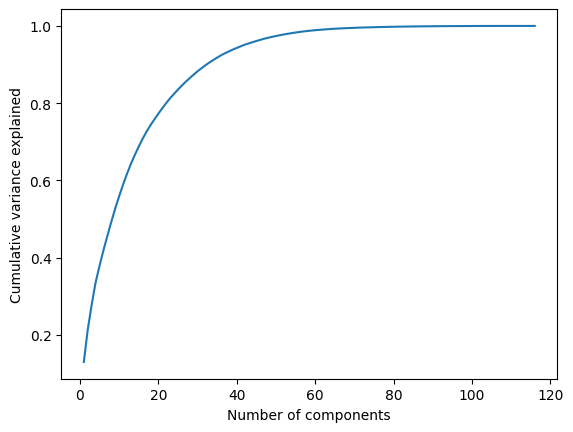

In [31]:
fig, ax = plt.subplots()
var_ratios = np.cumsum(pca.explained_variance_ratio_)
ax.plot(np.arange(1, len(var_ratios) +1), var_ratios)
ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative variance explained")

In [32]:
fig = px.scatter_3d(
    transformed_df, 
    x='PC1', y='PC2', z='PC3',
    color='Condition', 
    opacity=1,
    size='TimeBins',
    # color_discrete_sequence=colors
)
fig.show()


### Do it for two features at once, SQUARE and TRIANGLE

In [30]:
# FEATURE_DIM = "Shape"
COND_TO_SPLIT = "MaxFeatMatches"
OTHER_COND = "RPEGroup"
# CONDITIONS = [COND_TO_SPLIT, FEATURE_DIM]
NUM_UNIQUE_CONDITIONS = 8
# FILTERS = {"RPEGroup": "less pos"}
FILTERS = {"Response": "Correct"}
DECODER_SEED=42
MIN_NUM_TRIALS = 20

def get_feat_beh(session, feat, shuffle):
    feat_beh = behavioral_utils.get_beh_model_labels_for_session_feat(session, feat, beh_path=SESS_BEHAVIOR_PATH)
    if shuffle:
        rng = np.random.default_rng(seed=DECODER_SEED)
        vals = feat_beh[COND_TO_SPLIT].values
        rng.shuffle(vals)
        feat_beh[COND_TO_SPLIT] = vals
    return feat_beh


def label_and_balance_sessions(session, features, feature_dim, shuffle):
    feat_behs = []
    for feat in features:
        feat_behs.append(get_feat_beh(session, feat, shuffle))
    beh = pd.concat(feat_behs)
    # subselect for correct 
    for filter_col, filter in FILTERS.items():
        beh = beh[beh[filter_col] == filter]
    conditions_cols = [COND_TO_SPLIT, OTHER_COND, feature_dim]
    enough_trials = behavioral_utils.validate_enough_trials_by_condition(
        beh, 
        conditions_cols, 
        MIN_NUM_TRIALS, 
        num_unique_conditions=NUM_UNIQUE_CONDITIONS
    )
    if not enough_trials:
        # print("Not enough trials for session {session}, skipping")
        return None
    beh = behavioral_utils.balance_trials_by_condition(beh, conditions_cols)
    beh["Condition"] = beh[feature_dim] + " " + beh[COND_TO_SPLIT].astype(str) + " " + beh[OTHER_COND]
    frs_path = SESS_SPIKES_PATH.format(
        sess_name=session, 
        pre_interval=PRE_INTERVAL, 
        event=EVENT, 
        post_interval=POST_INTERVAL, 
        interval_size=INTERVAL_SIZE
    )
    frs = pd.read_pickle(frs_path)
    frs["PseudoUnitID"] = int(session) * 100 + frs["UnitID"]
    frs = frs[frs.PseudoUnitID.isin(region_units.PseudoUnitID)]
    merged = pd.merge(beh, frs, on="TrialNumber")
    if len(merged) == 0:
        return None
    return merged

In [31]:
FEATURE_1 = "SQUARE"
FEATURE_2 = "TRIANGLE"
FEATURE_DIM = "Shape"

In [43]:
all_trials = valid_sess.apply(lambda x: label_and_balance_sessions(
    x.session_name, 
    [FEATURE_1,FEATURE_2], 
    FEATURE_DIM, 
    shuffle=False
), axis=1)
all_trials = all_trials.dropna()
all_trials = pd.concat(all_trials.values)


In [44]:
all_trials = all_trials[all_trials.TimeBins > 1.35]

In [45]:
all_trials.Condition.unique()
true_conds = [FEATURE_1 + ' True less pos', FEATURE_1 + ' True more pos', FEATURE_2 + ' True less pos', FEATURE_2 + ' True more pos']
false_conds = [FEATURE_1 + ' False less pos', FEATURE_1 + ' False more pos', FEATURE_2 + ' False less pos', FEATURE_2 + ' False more pos']
true_trials = all_trials[all_trials.Condition.isin(true_conds)]
false_trials = all_trials[all_trials.Condition.isin(false_conds)]


In [46]:
all_trials["PseudoTrialNumber"] = (all_trials.Session.astype(str) + all_trials.TrialNumber.astype(str)).astype(int)
all_trials.groupby("Condition").PseudoTrialNumber.nunique()

Condition
SQUARE False less pos      270
SQUARE False more pos      270
SQUARE True less pos       270
SQUARE True more pos       270
TRIANGLE False less pos    270
TRIANGLE False more pos    270
TRIANGLE True less pos     270
TRIANGLE True more pos     270
Name: PseudoTrialNumber, dtype: int64

In [59]:
true_trials["Condition"] = true_trials["Shape"] + " " + true_trials.RPEGroup
false_trials["Condition"] = false_trials["Shape"] + " " + false_trials.RPEGroup

/tmp/ipykernel_2798183/21154004.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2798183/21154004.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [61]:
transformed_df, pca_true = project_conditioned_firing_rates(true_trials)
transformed_df["ZeroedTimeBins"] = transformed_df.TimeBins - 1.3
# transformed_df["ZeroedTimeBins"] = transformed_df.TimeBins

In [63]:
fig = px.scatter_3d(
    transformed_df, 
    x='PC1', y='PC2', z='PC3',
    color='Condition', 
    opacity=1,
    size='ZeroedTimeBins',
    # color_discrete_sequence=colors
)
fig.write_html("/data/patrick_res/figures/pca_max.html")
fig.show()


In [64]:
transformed_df, pca_false = project_conditioned_firing_rates(false_trials)
transformed_df["ZeroedTimeBins"] = transformed_df.TimeBins - 1.3
# transformed_df["ZeroedTimeBins"] = transformed_df.TimeBins

fig = px.scatter_3d(
    transformed_df, 
    x='PC1', y='PC2', z='PC3',
    color='Condition', 
    opacity=1,
    size='ZeroedTimeBins',
    # color_discrete_sequence=colors
)
fig.write_html("/data/patrick_res/figures/pca_not_max.html")
fig.show()


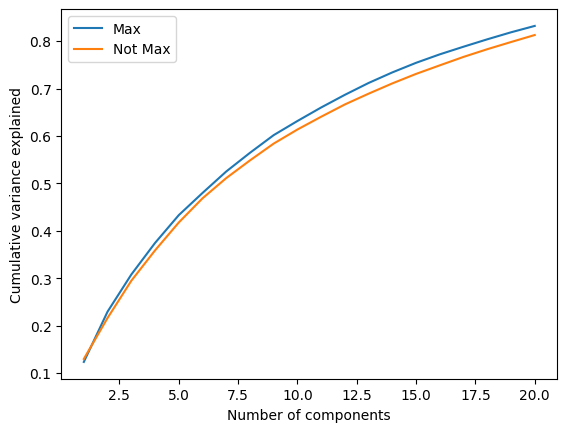

In [17]:
fig, ax = plt.subplots()
true_var_ratios = np.cumsum(pca_true.explained_variance_ratio_[:20])
false_var_ratios = np.cumsum(pca_false.explained_variance_ratio_[:20])
ax.plot(np.arange(1, len(true_var_ratios) +1), true_var_ratios, label="Max")
ax.plot(np.arange(1, len(false_var_ratios) +1), false_var_ratios, label="Not Max")

ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative variance explained")
ax.legend()

### Shared subspaces?
For max or not: 
- Find PCAs for TRIANGLE, SQUARE separately. 
- Project activity onto other PC
- look at cross variance explained

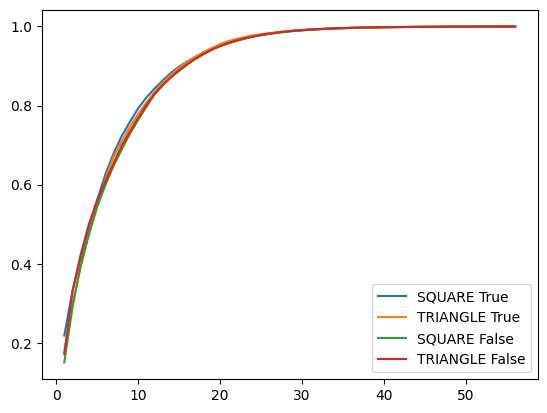

In [18]:
max_not = [True, False]
feats = [FEATURE_1, FEATURE_2]
conds = [(FEATURE_1, True), (FEATURE_2, True), (FEATURE_1, False), (FEATURE_2, False)]

fig, ax = plt.subplots()
pcas = {}
for feat, max in conds:
    trials = all_trials[(all_trials[FEATURE_DIM] == feat) & (all_trials.MaxFeatMatches == max)]
    _, pca = project_conditioned_firing_rates(trials)
    pcas[(feat, max)] = pca
    var_ratios = np.cumsum(pca.explained_variance_ratio_)
    ax.plot(np.arange(1, len(var_ratios) +1).astype(int), var_ratios, label=f"{feat} {max}")
ax.legend()


In [19]:
def calc_projected_var_ratios(trials, pca):
    data_mat, conditioned_frs = make_data_mat(trials)
    components = pca.components_
    transformed = components @ data_mat
    total_var = np.sum(data_mat ** 2)
    projected_vars_by_axes = np.sum(transformed ** 2, axis=1)
    var_ratios = projected_vars_by_axes / total_var
    return var_ratios

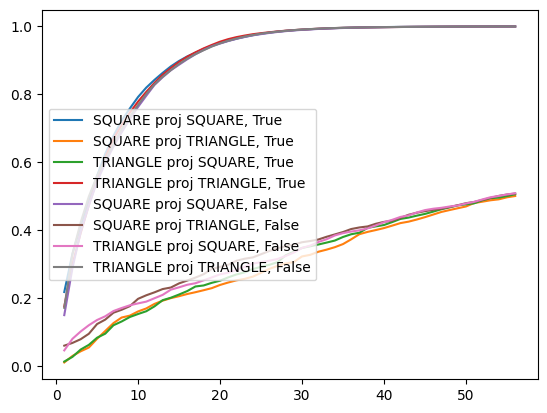

In [20]:
fig, ax = plt.subplots()
for max in max_not:
    for feature_trials in feats:
        for feature_pca in feats:
            trials = all_trials[(all_trials[FEATURE_DIM] == feature_trials) & (all_trials.MaxFeatMatches == max)]
            pca = pcas[(feature_pca, max)]
            var_ratios = calc_projected_var_ratios(trials, pca)
            var_ratios = np.cumsum(var_ratios)
            ax.plot(np.arange(1, len(var_ratios) +1).astype(int), var_ratios, label=f"{feature_trials} proj {feature_pca}, {max}")
ax.legend()
    

In [100]:
3 / 2

1.5